# Impact Analysis of human mobility and governmentinterventions effects on the spread of COVID-19
County Assigned: Jefferson County (Kentucky, US)

# Step 0: Data Acquisition

Importing the necessary packages

In [2]:
import pandas as pd
import numpy as np

import matplotlib.dates
import plotly.offline as py
py.init_notebook_mode()
%matplotlib inline
import matplotlib.dates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import seaborn as sns

Retrieving data from the data sources

In [3]:

raw_us_cases = pd.read_csv("RAW_us_confirmed_cases.csv")
mask_use_by_county = pd.read_csv("mask-use-by-county.csv")
mask_mandates_april_2020_aug_2021 = pd.read_csv("U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv")

# filtering the data for Jefferson County (KY state)
raw_jefferson_cases = raw_us_cases[(raw_us_cases["Province_State"] == "Kentucky") & (raw_us_cases["Admin2"] == "Jefferson")]

raw_data= pd.read_csv('US_KY_21111.csv')
gov_df=pd.read_csv('oxford-government-response_ky.csv')
gov_df = gov_df[(gov_df["location_key"] == "US_KY")]

# Step 1: Data Cleaning and consolidation

In [4]:
#lets take all the columns with cases by date and pivot the table + make the date its own column. Schema of date, cases

jefferson_cases_by_date =  raw_jefferson_cases[raw_jefferson_cases.columns[12:]]
jefferson_cases_by_date = pd.DataFrame(jefferson_cases_by_date.iloc[0])
jefferson_cases_by_date = jefferson_cases_by_date.reset_index()
jefferson_cases_by_date.columns = ["date", "cases"]
jefferson_mask_mandates_april_2020_aug_2021 = mask_mandates_april_2020_aug_2021[(mask_mandates_april_2020_aug_2021["State_Tribe_Territory"] == "KY") &\
     (mask_mandates_april_2020_aug_2021['County_Name'] == 'Jefferson County')]

#lets set N/A values from before mandates came into effect to no. Technically people were not required to wear masks when covid did not exist in the state, no works here.
jefferson_mask_mandates_april_2020_aug_2021["Face_Masks_Required_in_Public"] = jefferson_mask_mandates_april_2020_aug_2021["Face_Masks_Required_in_Public"].fillna("No")


#to obtain the daily confirmed case count from the cumulative count for all dates

jefferson_cases_by_date['cases']=jefferson_cases_by_date['cases'] - jefferson_cases_by_date.shift(periods=1)['cases']

<ipython-input-4-1bd312cd360d>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [5]:
#setting NaN value for the first date ( starting date) to zero
jefferson_cases_by_date['cases'].fillna(0)

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
         ...  
1009       0.0
1010       0.0
1011       0.0
1012    1248.0
1013       0.0
Name: cases, Length: 1014, dtype: float64

In [6]:
# filtering out the raw_df meta dataframe for information pertaining to only mobility 
mobility_df = raw_data[['date','mobility_retail_and_recreation','mobility_grocery_and_pharmacy','mobility_parks','mobility_transit_stations','mobility_workplaces','mobility_residential']]

In [7]:
# For Merging mask mandate data and the confirmed cases data on field= date
masks_df = jefferson_mask_mandates_april_2020_aug_2021[['date','Face_Masks_Required_in_Public']]

masks_df = masks_df.rename(columns = {'Face_Masks_Required_in_Public': 'mask_required'})
masks_df.head(100)

date mask_required
278768  4/10/2020            No
278769  4/11/2020            No
278770  4/12/2020            No
278771  4/13/2020            No
278772  4/14/2020            No
...           ...           ...
278863  7/14/2020           Yes
278864  7/15/2020           Yes
278865  7/16/2020           Yes
278866  7/17/2020           Yes
278867  7/18/2020           Yes

[100 rows x 2 columns]

In [8]:
#to merge case information, mask mandate information and mobility information into one data frame

jefferson_cases_by_date['date'] = pd.to_datetime(jefferson_cases_by_date['date'])
masks_df['date']=pd.to_datetime(masks_df['date'])
mobility_df['date']=pd.to_datetime(mobility_df['date'])

<ipython-input-8-654227fc8081>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [9]:
df =pd.merge(jefferson_cases_by_date,masks_df, on='date', how='inner')

df = pd.merge(df, mobility_df,on='date', how='inner')

In [10]:
#viewing the merged data
df.head()

date  cases mask_required  mobility_retail_and_recreation  \
0 2020-04-10    0.0            No                           -39.0   
1 2020-04-11    0.0            No                           -44.0   
2 2020-04-12  115.0            No                           -64.0   
3 2020-04-13   55.0            No                           -43.0   
4 2020-04-14  -19.0            No                           -38.0   

   mobility_grocery_and_pharmacy  mobility_parks  mobility_transit_stations  \
0                            0.0            53.0                      -30.0   
1                            5.0           104.0                      -27.0   
2                          -31.0           -28.0                      -47.0   
3                          -12.0           -16.0                      -38.0   
4                           -5.0            16.0                      -31.0   

   mobility_workplaces  mobility_residential  
0                -55.0                  23.0  
1                -40.0                  12.0  
2                -46.0                  12.0  
3                -50.0                  20.0  
4                -49.0                  20.0

In [11]:
df.columns

Index(['date', 'cases', 'mask_required', 'mobility_retail_and_recreation',
       'mobility_grocery_and_pharmacy', 'mobility_parks',
       'mobility_transit_stations', 'mobility_workplaces',
       'mobility_residential'],
      dtype='object')

In [12]:
#taking the moving average of cases to remove inconsistencies in the data
df['rolled_cases']=df['cases'].rolling(7).mean()
df['rolled_cases']=df['rolled_cases'].fillna(0)

In [13]:
#to obain percentage changes in the daily cases
df['y']=df['rolled_cases'].pct_change()
df['y']=df['y'].fillna(0)
df['y']= df['y']*100
df['y']=df['y'].replace([np.inf, -np.inf], np.nan).dropna()
df['y']=df['y'].fillna(0)

In [14]:
df

date  cases mask_required  mobility_retail_and_recreation  \
0   2020-04-10    0.0            No                           -39.0   
1   2020-04-11    0.0            No                           -44.0   
2   2020-04-12  115.0            No                           -64.0   
3   2020-04-13   55.0            No                           -43.0   
4   2020-04-14  -19.0            No                           -38.0   
..         ...    ...           ...                             ...   
488 2021-08-11  344.0            No                            -9.0   
489 2021-08-12  313.0            No                           -11.0   
490 2021-08-13  484.0            No                           -10.0   
491 2021-08-14  291.0            No                           -11.0   
492 2021-08-15  335.0            No                           -11.0   

     mobility_grocery_and_pharmacy  mobility_parks  mobility_transit_stations  \
0                              0.0            53.0                      -30.0   
1                              5.0           104.0                      -27.0   
2                            -31.0           -28.0                      -47.0   
3                            -12.0           -16.0                      -38.0   
4                             -5.0            16.0                      -31.0   
..                             ...             ...                        ...   
488                           13.0            52.0                      -13.0   
489                            9.0            34.0                      -15.0   
490                            8.0            61.0                      -14.0   
491                            8.0           200.0                      -12.0   
492                            2.0            58.0                      -21.0   

     mobility_workplaces  mobility_residential  rolled_cases         y  
0                  -55.0                  23.0      0.000000  0.000000  
1                  -40.0                  12.0      0.000000  0.000000  
2                  -46.0                  12.0      0.000000  0.000000  
3                  -50.0                  20.0      0.000000  0.000000  
4                  -49.0                  20.0      0.000000  0.000000  
..                   ...                   ...           ...       ...  
488                -33.0                   6.0    285.714286  2.880658  
489                -32.0                   6.0    282.571429 -1.100000  
490                -33.0                   5.0    306.857143  8.594540  
491                -13.0                   0.0    302.000000 -1.582868  
492                -14.0                   1.0    310.857143  2.932829  

[493 rows x 11 columns]

# Step 2: Analysis and Visualization

Visualizing the percentage change mobility trends prior and post-maskdate policy in place

For mobility type- mobility_grocery_and_pharmacy

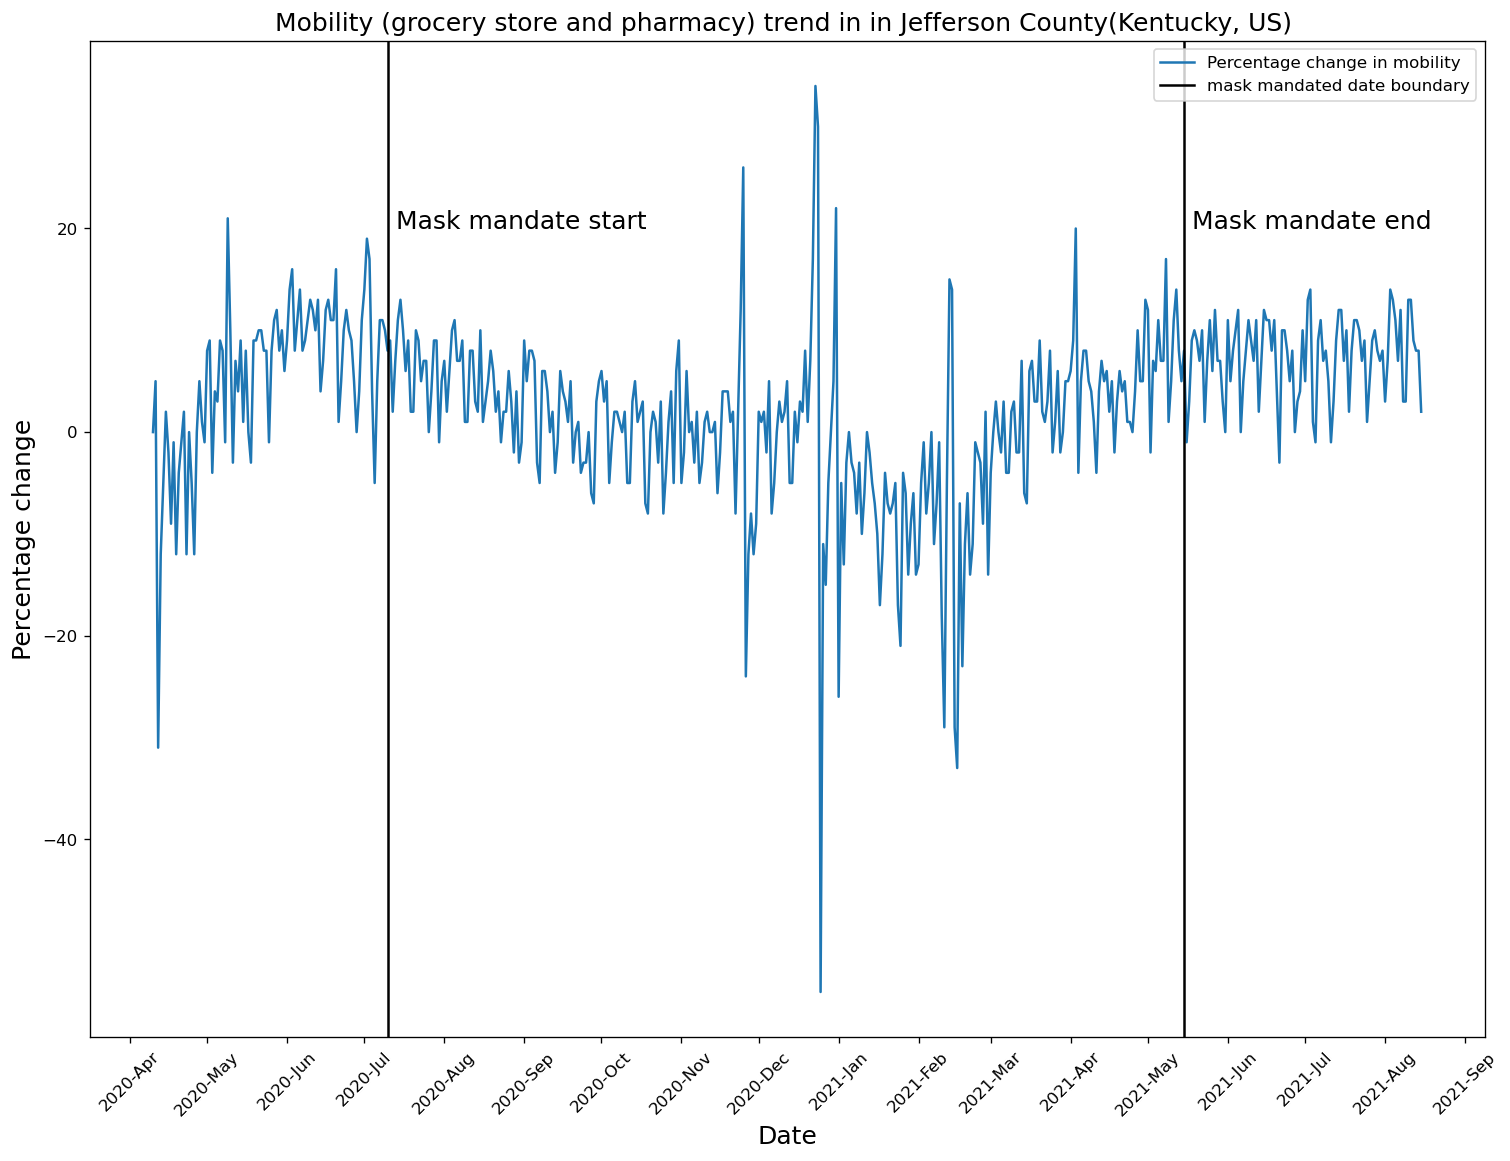

In [36]:
from matplotlib.pyplot import figure

figure(figsize=(15, 11), dpi=120) #defining plot size
plt.plot(df['date'],df['mobility_grocery_and_pharmacy'], label='Percentage change in mobility')


plt.axvline(pd.Timestamp('2020-07-10'), color='black', label='mask mandated date boundary')
plt.axvline(pd.Timestamp('2021-05-15'), color='black')
plt.annotate(' Mask mandate start', xy=(pd.to_datetime('2020-07-10'), 20), xytext=(pd.to_datetime('2020-07-10'), 20), fontsize = 15)
plt.annotate(' Mask mandate end', xy=(pd.to_datetime('2021-05-15'), 20), xytext=(pd.to_datetime('2021-05-15'), 20), fontsize = 15)



# define the date formatting in the X-axis
dtFmt = mdates.DateFormatter('%Y-%b') 
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# plt.axvline(pd.Timestamp('2020-04-10'),linestyle='--', color='black')
# plt.axvline(pd.Timestamp('2021-08-15'),linestyle='--', color='black')

plt.title('Mobility (grocery store and pharmacy) trend in in Jefferson County(Kentucky, US) ',fontsize = 15)
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Percentage change',fontsize = 15)
plt.xticks(rotation=45)
plt.legend(loc='best')

For mobility type- mobility_retail_and_recreation

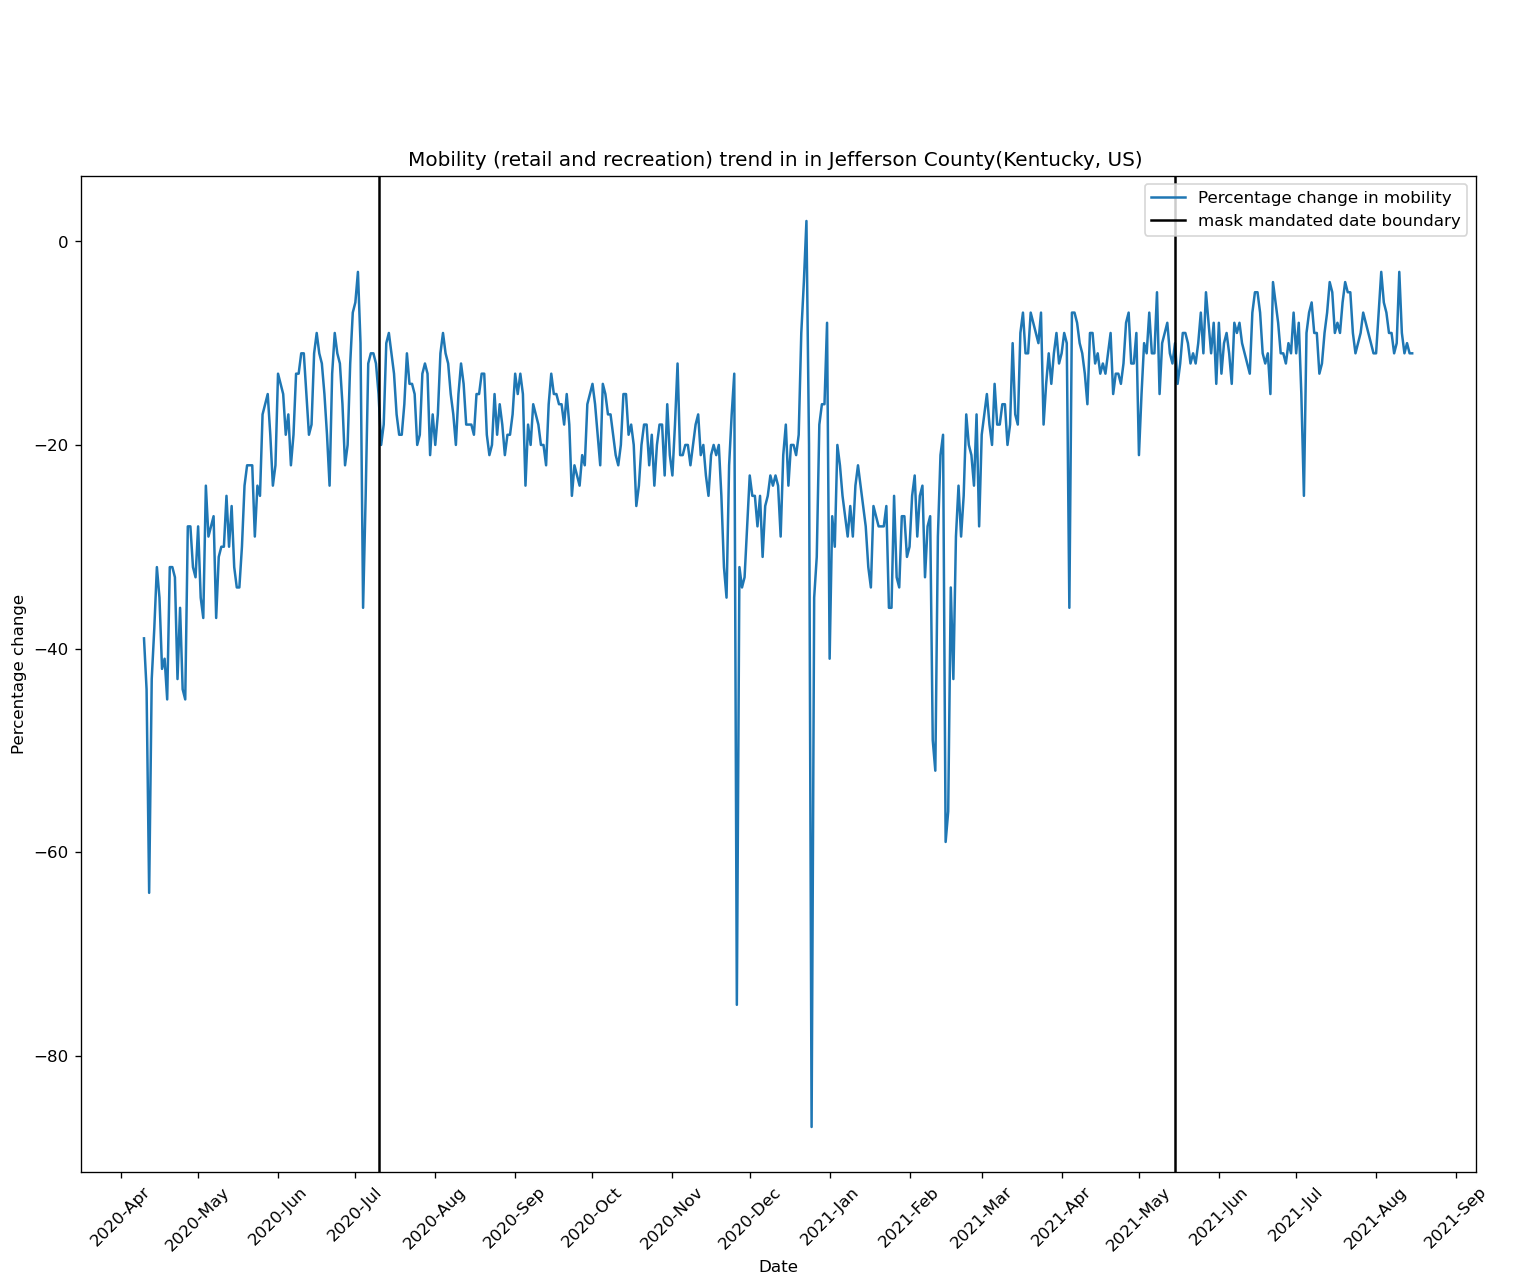

In [37]:

from matplotlib.pyplot import figure

figure(figsize=(15, 11), dpi=120) #defining plot size
plt.plot(df['date'],df['mobility_retail_and_recreation'], label='Percentage change in mobility')


plt.axvline(pd.Timestamp('2020-07-10'), color='black', label='mask mandated date boundary')
plt.axvline(pd.Timestamp('2021-05-15'), color='black')
plt.annotate(' Mask mandate start', xy=(pd.to_datetime('2020-07-10'), 20), xytext=(pd.to_datetime('2020-07-10'), 20), fontsize = 20 )
plt.annotate(' Mask mandate end', xy=(pd.to_datetime('2021-05-15'), 20), xytext=(pd.to_datetime('2021-05-15'), 20), fontsize = 20)



# define the date formatting in the X-axis
dtFmt = mdates.DateFormatter('%Y-%b') 
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# plt.axvline(pd.Timestamp('2020-04-10'),linestyle='--', color='black')
# plt.axvline(pd.Timestamp('2021-08-15'),linestyle='--', color='black')

plt.title('Mobility (retail and recreation) trend in in Jefferson County(Kentucky, US) ')
plt.xlabel('Date')
plt.ylabel('Percentage change')
plt.xticks(rotation=45)
plt.legend(loc='best')

For mobility type- mobility_transit_stations

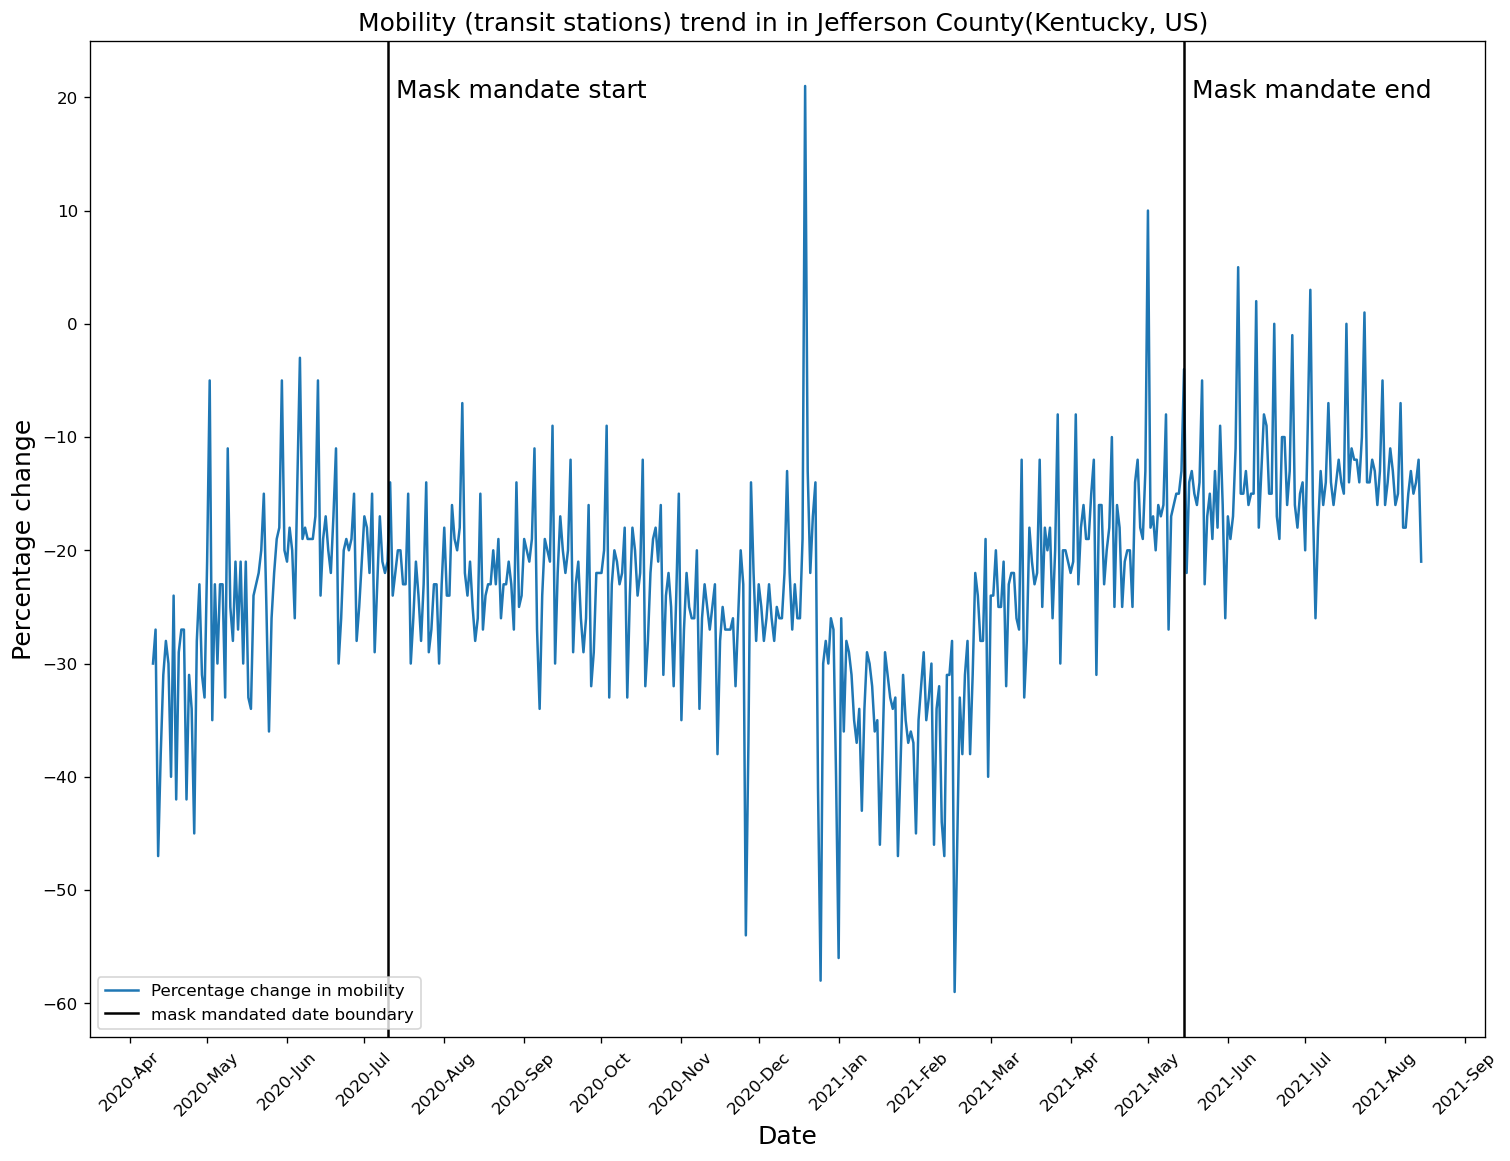

In [38]:

from matplotlib.pyplot import figure

figure(figsize=(15, 11), dpi=120) #defining plot size
plt.plot(df['date'],df['mobility_transit_stations'], label='Percentage change in mobility')


plt.axvline(pd.Timestamp('2020-07-10'), color='black', label='mask mandated date boundary')
plt.axvline(pd.Timestamp('2021-05-15'), color='black')
plt.annotate(' Mask mandate start', xy=(pd.to_datetime('2020-07-10'), 20), xytext=(pd.to_datetime('2020-07-10'), 20), fontsize = 15 )
plt.annotate(' Mask mandate end', xy=(pd.to_datetime('2021-05-15'), 20), xytext=(pd.to_datetime('2021-05-15'), 20), fontsize = 15)



# define the date formatting in the X-axis
dtFmt = mdates.DateFormatter('%Y-%b') 
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# plt.axvline(pd.Timestamp('2020-04-10'),linestyle='--', color='black')
# plt.axvline(pd.Timestamp('2021-08-15'),linestyle='--', color='black')

plt.title('Mobility (transit stations) trend in in Jefferson County(Kentucky, US) ', fontsize = 15)
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Percentage change',fontsize = 15)
plt.xticks(rotation=45)
plt.legend(loc='lower left')

For mobility type- mobility_workplaces

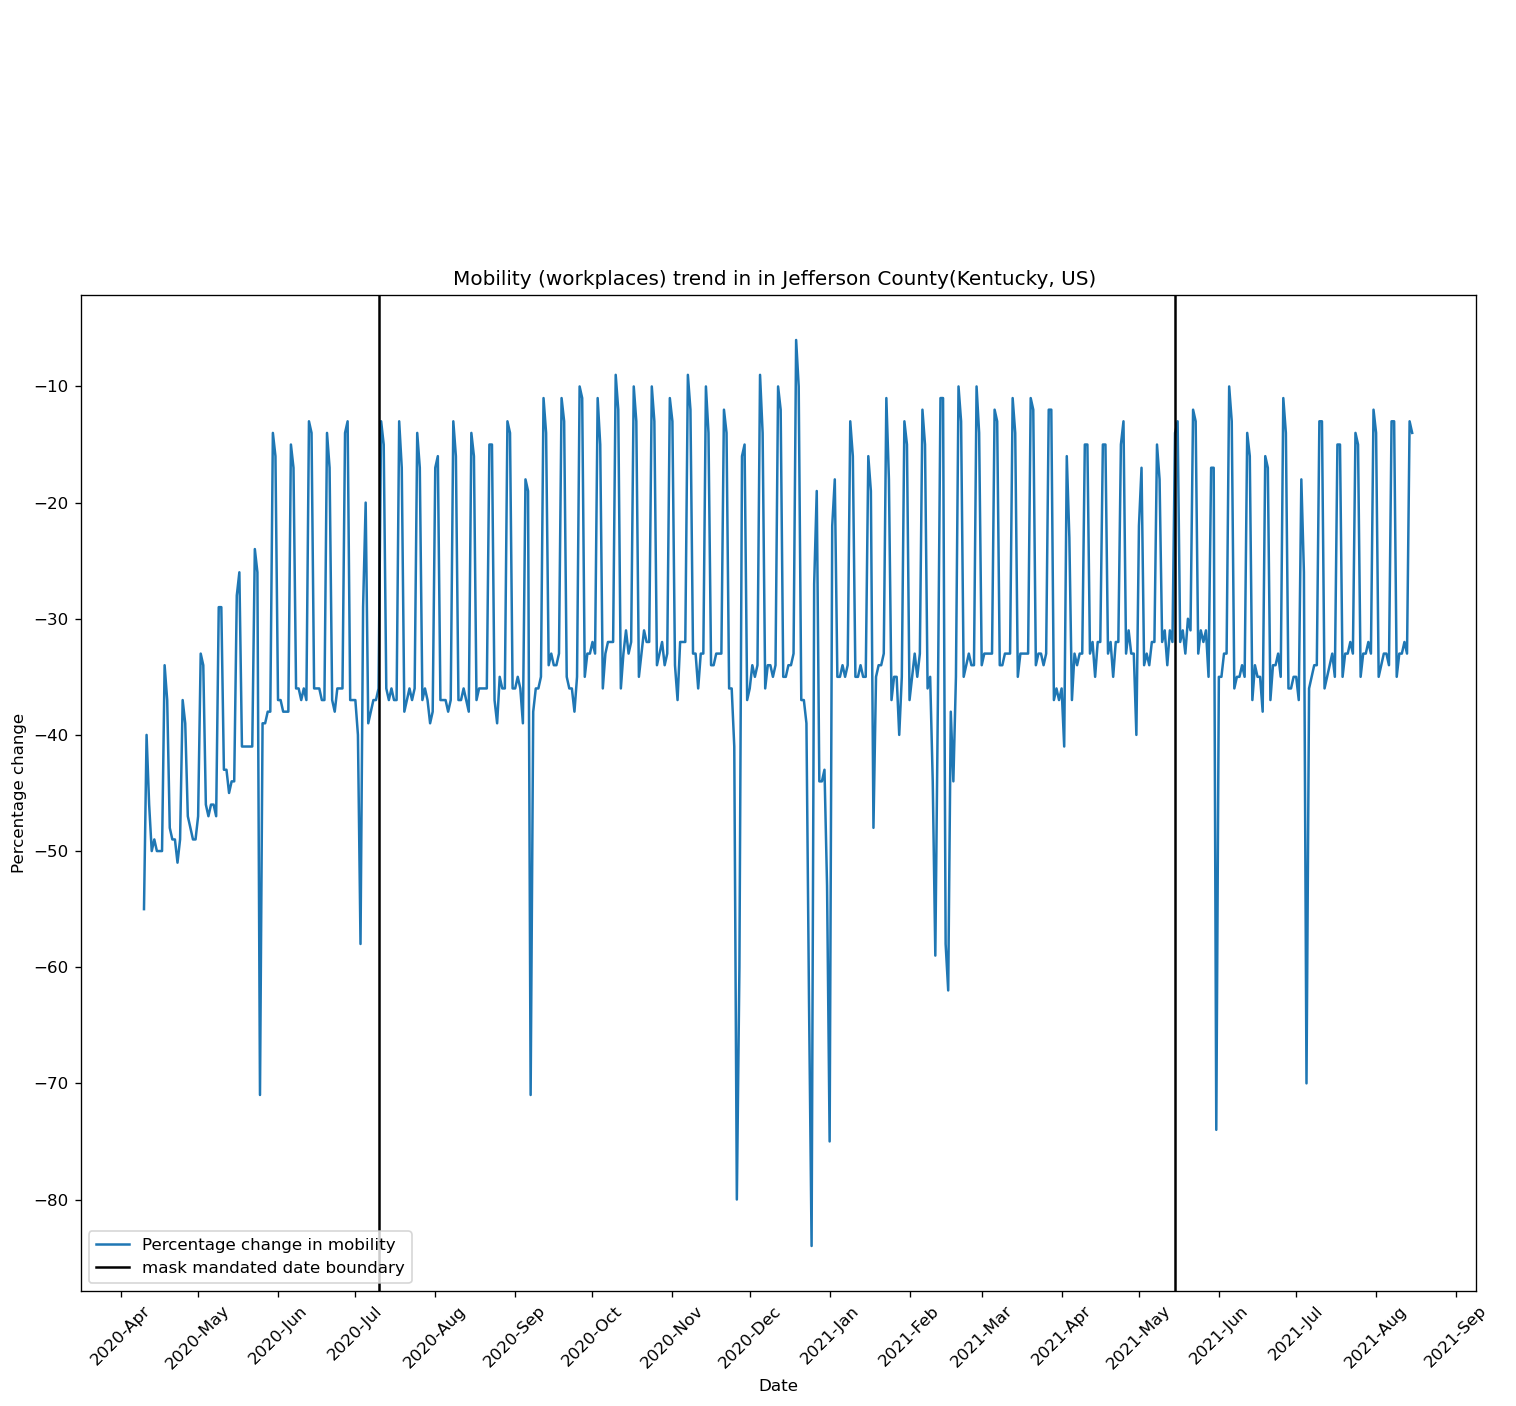

In [39]:

from matplotlib.pyplot import figure

figure(figsize=(15, 11), dpi=120) #defining plot size
plt.plot(df['date'],df['mobility_workplaces'], label='Percentage change in mobility')


plt.axvline(pd.Timestamp('2020-07-10'), color='black', label='mask mandated date boundary')
plt.axvline(pd.Timestamp('2021-05-15'), color='black')
plt.annotate(' Mask mandate start', xy=(pd.to_datetime('2020-07-10'), 20), xytext=(pd.to_datetime('2020-07-10'), 20), fontsize = 20 )
plt.annotate(' Mask mandate end', xy=(pd.to_datetime('2021-05-15'), 20), xytext=(pd.to_datetime('2021-05-15'), 20), fontsize = 20)



# define the date formatting in the X-axis
dtFmt = mdates.DateFormatter('%Y-%b') 
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# plt.axvline(pd.Timestamp('2020-04-10'),linestyle='--', color='black')
# plt.axvline(pd.Timestamp('2021-08-15'),linestyle='--', color='black')

plt.title('Mobility (workplaces) trend in in Jefferson County(Kentucky, US) ')
plt.xlabel('Date')
plt.ylabel('Percentage change')
plt.xticks(rotation=45)
plt.legend(loc='lower left')

For mobility type- mobility_residential

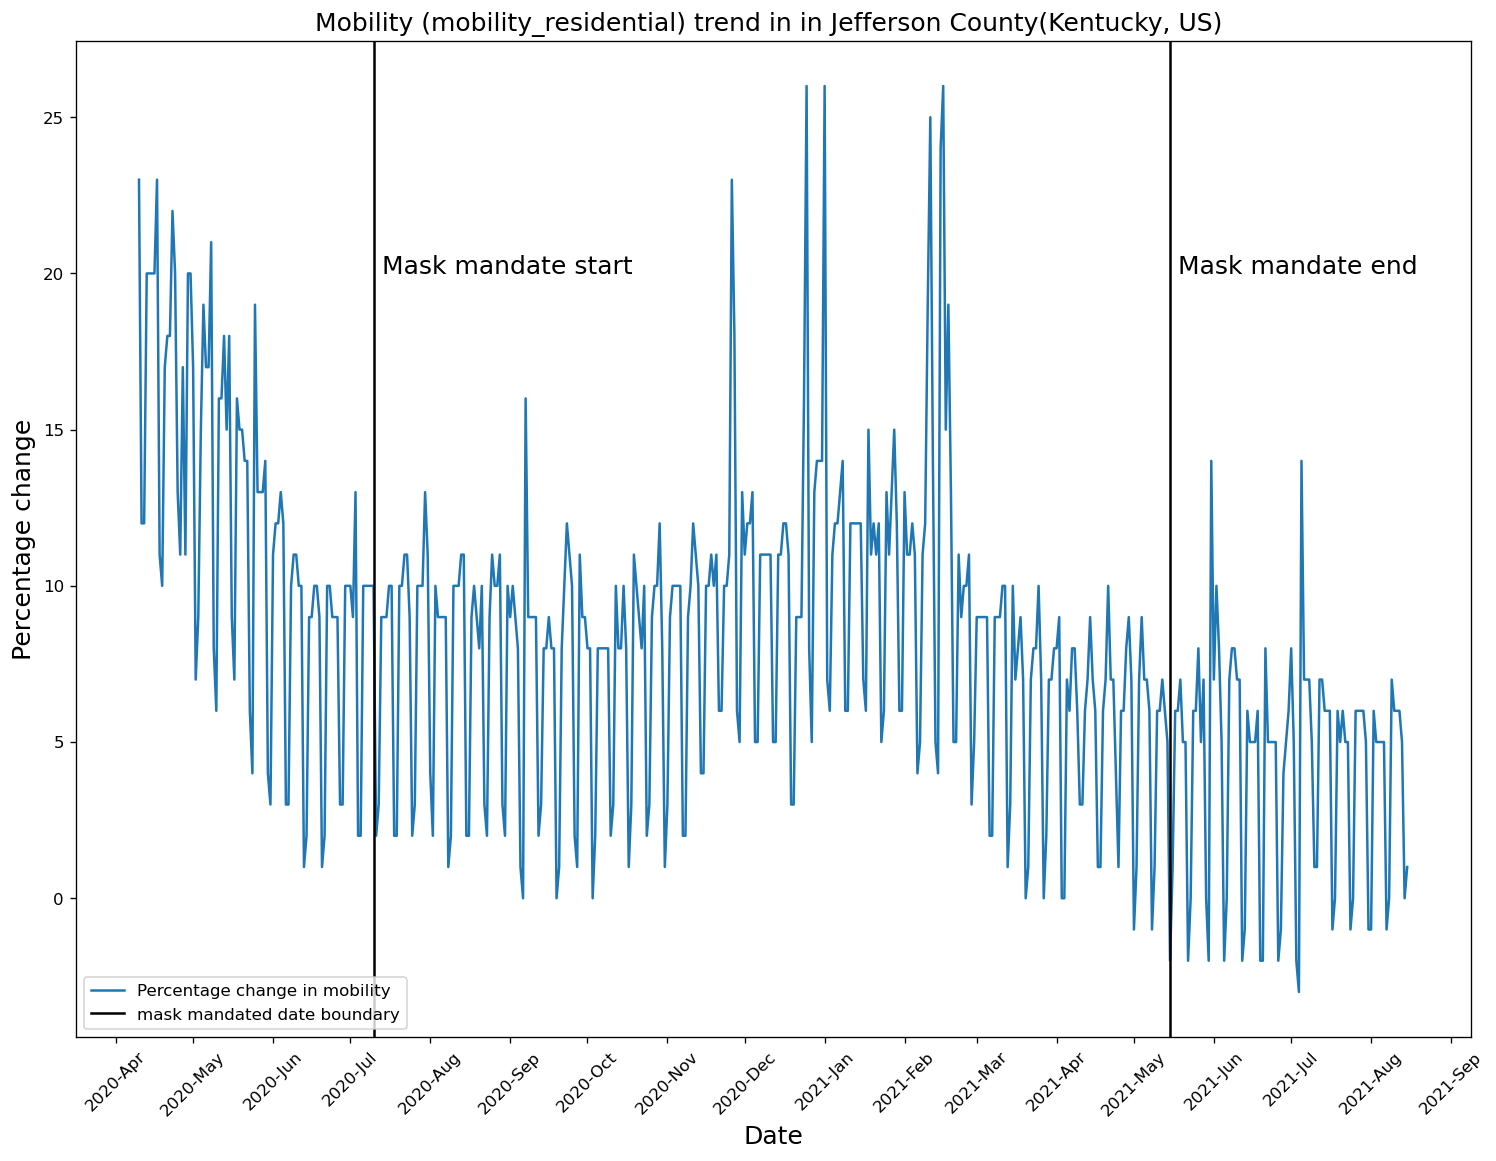

In [41]:

from matplotlib.pyplot import figure

figure(figsize=(15, 11), dpi=120) #defining plot size
plt.plot(df['date'],df['mobility_residential'], label='Percentage change in mobility')


plt.axvline(pd.Timestamp('2020-07-10'), color='black', label='mask mandated date boundary')
plt.axvline(pd.Timestamp('2021-05-15'), color='black')
plt.annotate(' Mask mandate start', xy=(pd.to_datetime('2020-07-10'), 20), xytext=(pd.to_datetime('2020-07-10'), 20), fontsize = 15 )
plt.annotate(' Mask mandate end', xy=(pd.to_datetime('2021-05-15'), 20), xytext=(pd.to_datetime('2021-05-15'), 20), fontsize = 15)



# define the date formatting in the X-axis
dtFmt = mdates.DateFormatter('%Y-%b') 
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# plt.axvline(pd.Timestamp('2020-04-10'),linestyle='--', color='black')
# plt.axvline(pd.Timestamp('2021-08-15'),linestyle='--', color='black')

plt.title('Mobility (mobility_residential) trend in in Jefferson County(Kentucky, US) ',fontsize = 15)
plt.xlabel('Date',fontsize = 15)
plt.ylabel('Percentage change',fontsize = 15)
plt.xticks(rotation=45)
plt.legend(loc='lower left')

For research question: 1) How has mobility changed with the government restrictions and policies in place?

Hypothesis:

Null: The mean difference in the percentage change in mobility prior to and post-mask mandates is not different from 0.
Alternative: The mean difference in the percentage change in mobility prior to and post-mask mandates is different from 0.

In [16]:
#creating two groups (dataframes) corresponding to data prior to and post-mask mandates to perform the paired t-tests

df['month'] = pd.DatetimeIndex(df['date']).month
no_mask_before = df[df['date'] < '2020-07-10']
mask_after = df[(df['date'] >= '2020-07-10') & (df['date'] <= '2021-06-10')]

df1 = no_mask_before
df2 = mask_after.head(91)

Performing dependent/paired t-tests

In [17]:
import scipy.stats as stats

#to run the tests and print the corresponding results
print('mobility_retail_and_recreation', stats.ttest_rel(df1['mobility_retail_and_recreation'], df2['mobility_retail_and_recreation']))
print('mobility_grocery_and_pharmacy', stats.ttest_rel(df1['mobility_grocery_and_pharmacy'], df2['mobility_grocery_and_pharmacy']))
print('mobility_transit_stations', stats.ttest_rel(df1['mobility_transit_stations'], df2['mobility_transit_stations']))
print('mobility_workplaces', stats.ttest_rel(df1['mobility_workplaces'], df2['mobility_workplaces']))
print('mobility_residential', stats.ttest_rel(df1['mobility_residential'], df2['mobility_residential']))


mobility_retail_and_recreation Ttest_relResult(statistic=-5.870410688859228, pvalue=7.1645936784317e-08)
mobility_grocery_and_pharmacy Ttest_relResult(statistic=1.7231112655087786, pvalue=0.08830260857061265)
mobility_transit_stations Ttest_relResult(statistic=-2.17505745734207, pvalue=0.03224745281168227)
mobility_workplaces Ttest_relResult(statistic=-8.122642639156433, pvalue=2.2770434864495385e-12)
mobility_residential Ttest_relResult(statistic=10.495044733103489, pvalue=2.6904803876874664e-17)


For research questions : 2) Which of the different government responses/policies have influenced mobility the most? 


Hypothesis: Mobility (of a particular type, say mobility to drug stores or pharmacies)
reduced by X% post a varied combination of government policy implementation on
the travel ban, masking regulations, and vaccination mandates

In [22]:
# merging government responses data and the case information into a single dataframe for the multi-linear-regression model fitting

temp_df=gov_df[['facial_coverings','school_closing','workplace_closing',
       'cancel_public_events', 'restrictions_on_gatherings',
       'public_transport_closing', 'stay_at_home_requirements',
       'restrictions_on_internal_movement', 'international_travel_controls','testing_policy', 
       'vaccination_policy','date']]
temp_df['date'] = pd.to_datetime(temp_df['date'])


test_df = pd.merge(df, temp_df,on='date', how='inner')

<ipython-input-22-dec479620219>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
#changing text to categorical variables for the model
test_df['mask_required'] = test_df['mask_required'].replace('Yes',1)
test_df['mask_required'] = test_df['mask_required'].replace('No',0)

Fitting a multi-linear regression model for mobility type: mobility_grocery_and_pharmacy

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

#defining independent and dependent variables
X = test_df[['mask_required','facial_coverings', 'school_closing', 'workplace_closing', 'cancel_public_events','restrictions_on_gatherings',
       'public_transport_closing','stay_at_home_requirements']]

Y= test_df['mobility_grocery_and_pharmacy']

#splitting train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

#model fitting
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

C:\Users\shubh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='mobility_grocery_and_pharmacy'>

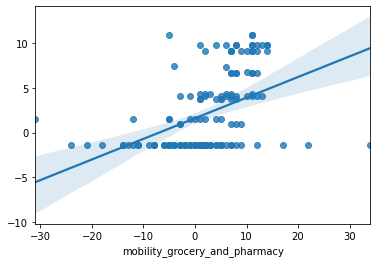

In [28]:
#plotting model predictions
predictions = model.predict(X_test)
sns.regplot(y_test,predictions)

In [29]:
#obtaining model summary
X_train_Sm= sm.add_constant(X_train)
X_train_Sm= sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm).fit()
print(ls.summary())

                                  OLS Regression Results                                 
Dep. Variable:     mobility_grocery_and_pharmacy   R-squared:                       0.263
Model:                                       OLS   Adj. R-squared:                  0.245
Method:                            Least Squares   F-statistic:                     14.99
Date:                           Mon, 12 Dec 2022   Prob (F-statistic):           8.54e-19
Time:                                   21:53:19   Log-Likelihood:                -1174.6
No. Observations:                            345   AIC:                             2367.
Df Residuals:                                336   BIC:                             2402.
Df Model:                                      8                                         
Covariance Type:                       nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----

Fitting a multi-linear regression model for mobility type: mobility_retail_and_recreation

In [30]:
X = test_df[['mask_required','facial_coverings', 'school_closing', 'workplace_closing', 'cancel_public_events','restrictions_on_gatherings',
       'public_transport_closing','stay_at_home_requirements']]

Y= test_df['mobility_retail_and_recreation']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)
model = LinearRegression()
model.fit(X_train,y_train)

#obtaining model summary
X_train_Sm= sm.add_constant(X_train)
X_train_Sm= sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm).fit()
print(ls.summary())

                                  OLS Regression Results                                  
Dep. Variable:     mobility_retail_and_recreation   R-squared:                       0.466
Model:                                        OLS   Adj. R-squared:                  0.453
Method:                             Least Squares   F-statistic:                     36.58
Date:                            Mon, 12 Dec 2022   Prob (F-statistic):           1.65e-41
Time:                                    21:54:58   Log-Likelihood:                -1173.6
No. Observations:                             345   AIC:                             2365.
Df Residuals:                                 336   BIC:                             2400.
Df Model:                                       8                                         
Covariance Type:                        nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.

Fitting a multi-linear regression model for mobility type: mobility_transit_stations

In [31]:
X = test_df[['mask_required','facial_coverings', 'school_closing', 'workplace_closing', 'cancel_public_events','restrictions_on_gatherings',
       'public_transport_closing','stay_at_home_requirements']]

Y= test_df['mobility_transit_stations']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)
model = LinearRegression()
model.fit(X_train,y_train)

#obtaining model summary
X_train_Sm= sm.add_constant(X_train)
X_train_Sm= sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm).fit()
print(ls.summary())

                                OLS Regression Results                               
Dep. Variable:     mobility_transit_stations   R-squared:                       0.338
Model:                                   OLS   Adj. R-squared:                  0.322
Method:                        Least Squares   F-statistic:                     21.45
Date:                       Mon, 12 Dec 2022   Prob (F-statistic):           2.58e-26
Time:                               21:55:33   Log-Likelihood:                -1200.5
No. Observations:                        345   AIC:                             2419.
Df Residuals:                            336   BIC:                             2454.
Df Model:                                  8                                         
Covariance Type:                   nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

Fitting a multi-linear regression model for mobility type: mobility_workplaces

In [32]:
X = test_df[['mask_required','facial_coverings', 'school_closing', 'workplace_closing', 'cancel_public_events','restrictions_on_gatherings',
       'public_transport_closing','stay_at_home_requirements']]

Y= test_df['mobility_workplaces']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)
model = LinearRegression()
model.fit(X_train,y_train)

#obtaining model summary
X_train_Sm= sm.add_constant(X_train)
X_train_Sm= sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm).fit()
print(ls.summary())

                             OLS Regression Results                            
Dep. Variable:     mobility_workplaces   R-squared:                       0.119
Model:                             OLS   Adj. R-squared:                  0.098
Method:                  Least Squares   F-statistic:                     5.650
Date:                 Mon, 12 Dec 2022   Prob (F-statistic):           9.66e-07
Time:                         21:56:07   Log-Likelihood:                -1330.6
No. Observations:                  345   AIC:                             2679.
Df Residuals:                      336   BIC:                             2714.
Df Model:                            8                                         
Covariance Type:             nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const     

Fitting a multi-linear regression model for mobility type: mobility_residential

In [33]:
X = test_df[['mask_required','facial_coverings', 'school_closing', 'workplace_closing', 'cancel_public_events','restrictions_on_gatherings',
       'public_transport_closing','stay_at_home_requirements']]

Y= test_df['mobility_residential']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)
model = LinearRegression()
model.fit(X_train,y_train)

#obtaining model summary
X_train_Sm= sm.add_constant(X_train)
X_train_Sm= sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm).fit()
print(ls.summary())

                             OLS Regression Results                             
Dep. Variable:     mobility_residential   R-squared:                       0.336
Model:                              OLS   Adj. R-squared:                  0.320
Method:                   Least Squares   F-statistic:                     21.26
Date:                  Mon, 12 Dec 2022   Prob (F-statistic):           4.16e-26
Time:                          21:56:49   Log-Likelihood:                -994.14
No. Observations:                   345   AIC:                             2006.
Df Residuals:                       336   BIC:                             2041.
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


For research questions :3) Which of the different government responses/policies have influenced the COVID-19 spread the most?

Hypothesis: COVID-19 cases reduced by X% post a varied combination of
government policy implementation on the travel ban, masking regulations, and
vaccination mandates

In [35]:
test_df['y']=df['y'] #to set daily cases as the dependent variable for the model

#defining the independent and dependent variables
X = test_df[['mask_required','facial_coverings', 'school_closing', 'workplace_closing', 'cancel_public_events','restrictions_on_gatherings',
       'public_transport_closing','stay_at_home_requirements']]

Y= test_df['y']

#splitting the train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

#model fitting
model = LinearRegression()
model.fit(X_train,y_train)

#obtaining model summary
X_train_Sm= sm.add_constant(X_train)
X_train_Sm= sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     2.801
Date:                Mon, 12 Dec 2022   Prob (F-statistic):            0.00514
Time:                        21:58:17   Log-Likelihood:                -1317.3
No. Observations:                 345   AIC:                             2653.
Df Residuals:                     336   BIC:                             2687.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

Checking lag: Visualization to access whether mobility habits influenced the spread of the COVID-19

In [69]:
#obtaining the change points in all the time series information

import ruptures as rpt

#changepoints for all mobility types
mob_groc = np.array(df["mobility_grocery_and_pharmacy"])
algo2 = rpt.Pelt(model="rbf").fit(mob_groc)

change_groc= algo2.predict(pen=10)
#change_locations2 = merged_df.iloc[change_locations2[:-1]].index.to_list()


mob_rec = np.array(df["mobility_retail_and_recreation"])
algo3 = rpt.Pelt(model="rbf").fit(mob_rec)

change_rec= algo3.predict(pen=10)

mob_tran = np.array(df["mobility_transit_stations"])
algo5 = rpt.Pelt(model="rbf").fit(mob_tran)

change_tran= algo5.predict(pen=10)


mob_work = np.array(df["mobility_workplaces"])
algo6 = rpt.Pelt(model="rbf").fit(mob_work)

change_work= algo6.predict(pen=10)

mob_resi = np.array(df["mobility_residential"])
algo7 = rpt.Pelt(model="rbf").fit(mob_resi)

change_resi= algo7.predict(pen=10)

#changepoints obtained from Part1- Common Analysis
change_locations2 = [175, 270, 395, 560, 610, 700, 770]

For changepoints in daily case rates and mobility of type- mobility_retail_and_recreation

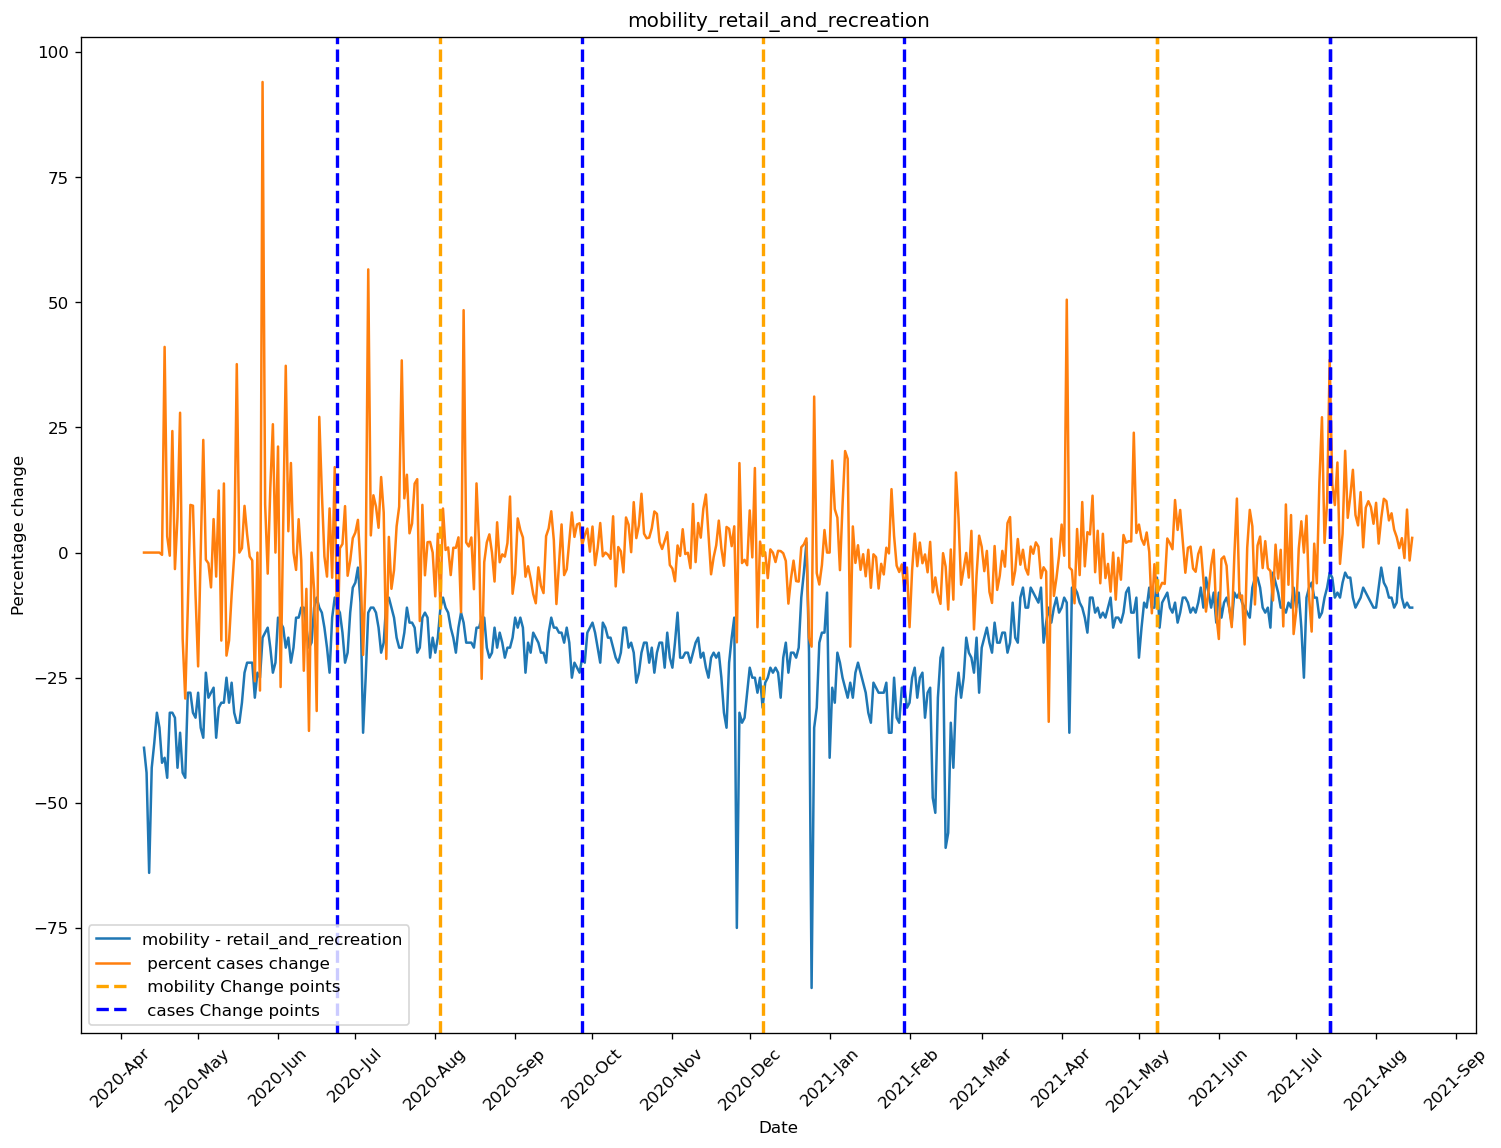

In [71]:
#for plotting the final visualization

from matplotlib.pyplot import figure



red_dates= mobility_df.iloc[change_rec]['date'].to_numpy()


blue_dates= mobility_df.iloc[change_locations2]['date'].to_numpy()



figure(figsize=(15, 11), dpi=120) #defining plot size
plt.plot(df['date'],df['mobility_retail_and_recreation'], label='mobility trend') 
plt.plot(df['date'],df['y'], label=' percent cases change ') 

#plt.plot(jefferson_cases_by_date['date'],jefferson_cases_by_date['cases']) 
#plt.plot(mobility_df['date'],mobility_df['mobility_grocery_and_pharmacy'], label='grocerices') 
for i in df.loc[df['date'].isin(red_dates),'date'].to_numpy():
    plt.axvline(i,lw=2,linestyle='--', color='orange')
plt.axvline(i,lw=2, color='orange', linestyle='--',label=' mobility Change points')

for i in df.loc[df['date'].isin(blue_dates),'date'].to_numpy():
    plt.axvline(i,lw=2,linestyle='--', color='blue')
plt.axvline(i,lw=2, color='blue', linestyle='--', label=' cases Change points')

# define the date formatting in the X-axis
dtFmt = mdates.DateFormatter('%Y-%b') 
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# plt.axvline(pd.Timestamp('2020-04-10'),linestyle='--', color='black')
# plt.axvline(pd.Timestamp('2021-08-15'),linestyle='--', color='black')

plt.title('mobility_retail_and_recreation')
plt.xlabel('Date')
plt.ylabel('Percentage change')
plt.xticks(rotation=45)
plt.legend(loc='best')

In [ ]:
For changepoints in daily case rates and mobility of type- mobility_grocery_and_pharmacy

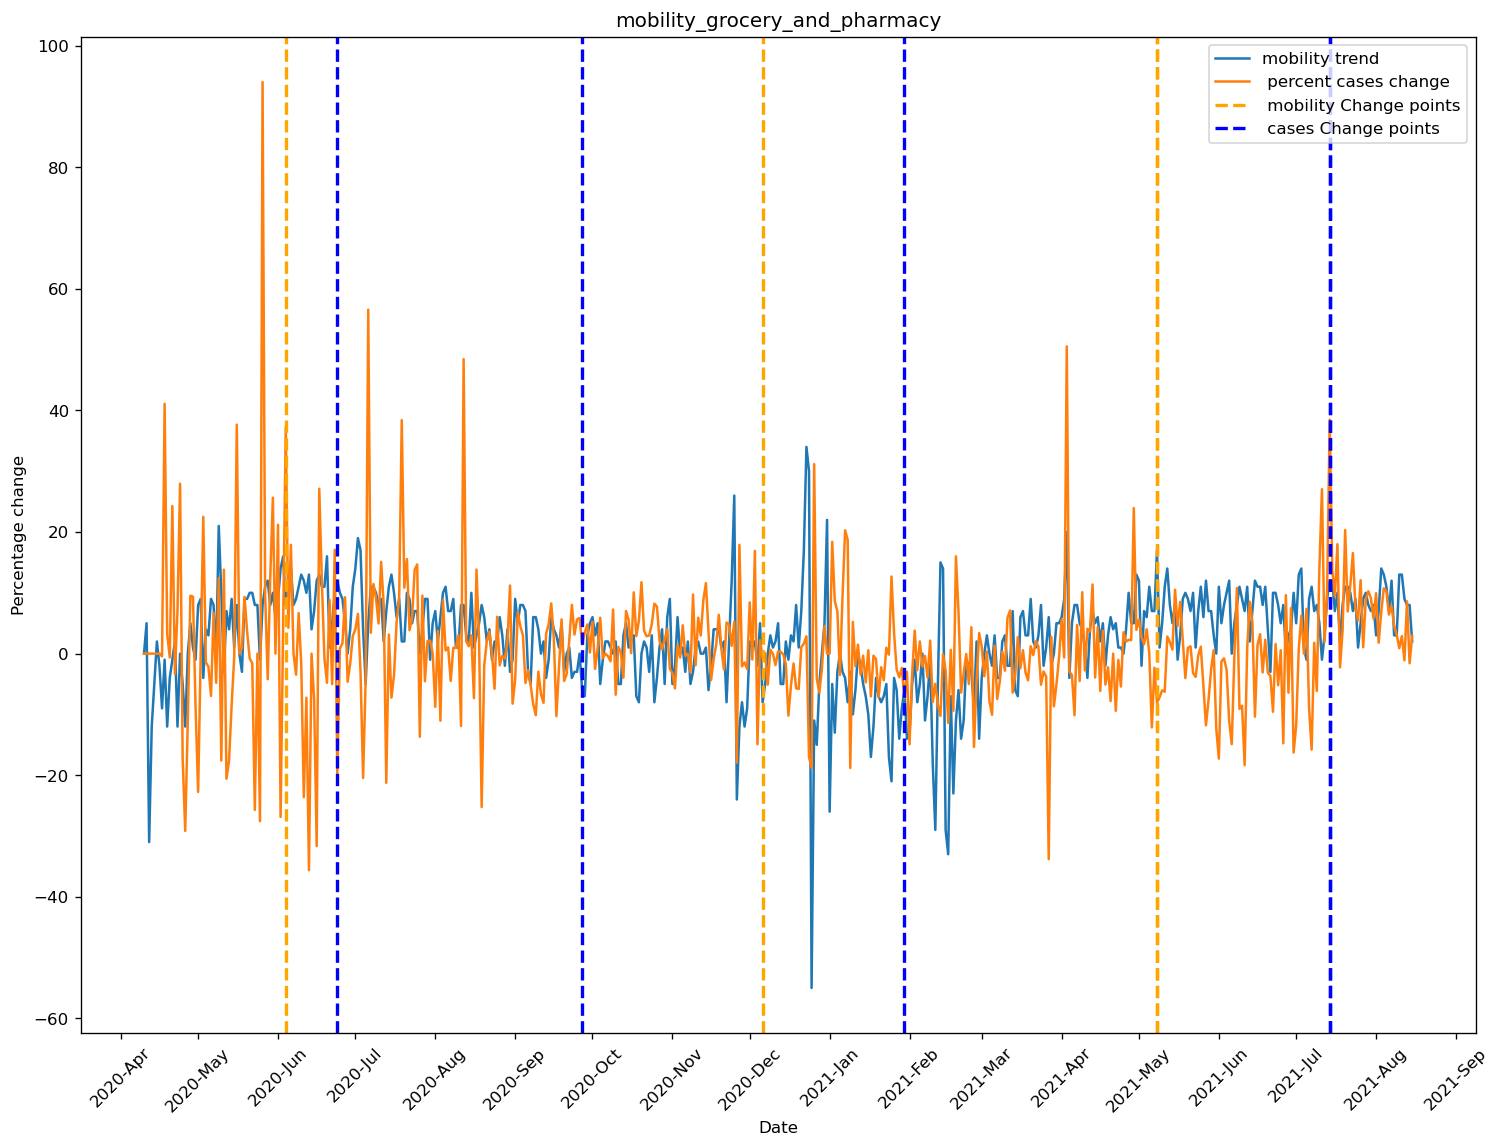

In [72]:
#for plotting the final visualization

from matplotlib.pyplot import figure



red_dates= mobility_df.iloc[change_groc]['date'].to_numpy()


blue_dates= mobility_df.iloc[change_locations2]['date'].to_numpy()



figure(figsize=(15, 11), dpi=120) #defining plot size
plt.plot(df['date'],df['mobility_grocery_and_pharmacy'], label='mobility trend') 
plt.plot(df['date'],df['y'], label=' percent cases change ') 

#plt.plot(jefferson_cases_by_date['date'],jefferson_cases_by_date['cases']) 
#plt.plot(mobility_df['date'],mobility_df['mobility_grocery_and_pharmacy'], label='grocerices') 
for i in df.loc[df['date'].isin(red_dates),'date'].to_numpy():
    plt.axvline(i,lw=2,linestyle='--', color='orange')
plt.axvline(i,lw=2, color='orange', linestyle='--',label=' mobility Change points')

for i in df.loc[df['date'].isin(blue_dates),'date'].to_numpy():
    plt.axvline(i,lw=2,linestyle='--', color='blue')
plt.axvline(i,lw=2, color='blue', linestyle='--', label=' cases Change points')

# define the date formatting in the X-axis
dtFmt = mdates.DateFormatter('%Y-%b') 
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# plt.axvline(pd.Timestamp('2020-04-10'),linestyle='--', color='black')
# plt.axvline(pd.Timestamp('2021-08-15'),linestyle='--', color='black')

plt.title('mobility_grocery_and_pharmacy')
plt.xlabel('Date')
plt.ylabel('Percentage change')
plt.xticks(rotation=45)
plt.legend(loc='best')

Taking one mobility type (here - mobility_grocery_and_pharmacy) to plot a final visualization to properly highlight the lag between daily case rate and mobility time-series data

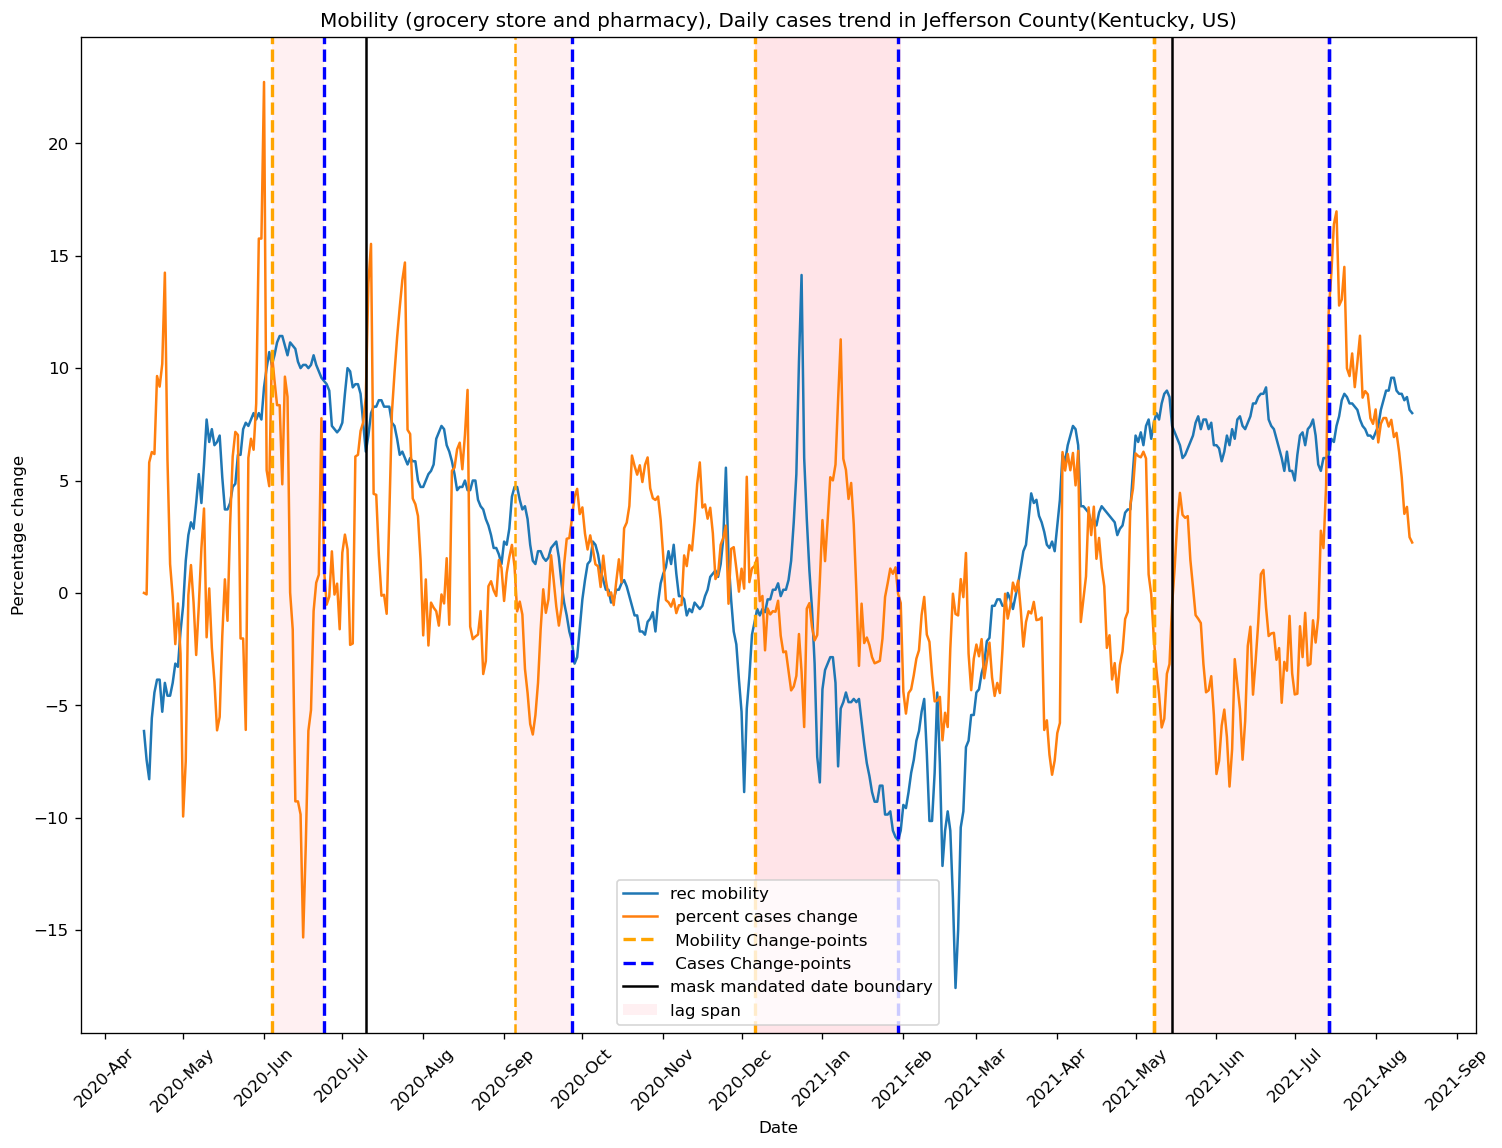

In [73]:
#for plotting the final visualization

from matplotlib.pyplot import figure


red_dates= mobility_df.iloc[change_groc]['date'].to_numpy()
blue_dates= mobility_df.iloc[change_locations2]['date'].to_numpy()


figure(figsize=(15, 11), dpi=120) #defining plot size
plt.plot(df['date'],df['mobility_grocery_and_pharmacy'].rolling(7).mean(), label='rec mobility') 
plt.plot(df['date'],df['y'].rolling(7).mean(), label=' percent cases change ') 


plt.axvspan('2020-06-04','2020-06-24', facecolor='lightpink', alpha=0.2, label='lag span')
plt.axvspan('2020-12-06','2021-01-31', facecolor='lightpink', alpha=0.2)
plt.axvspan('2020-12-06','2021-01-31', facecolor='lightpink', alpha=0.2)
plt.axvspan('2021-05-08','2021-07-14', facecolor='lightpink', alpha=0.2)
plt.axvspan('2020-09-05','2020-09-27', facecolor='lightpink', alpha=0.2)

plt.axvline(pd.Timestamp('2020-09-05'),linestyle='--', color='orange')
 
for i in df.loc[df['date'].isin(red_dates),'date'].to_numpy():
    plt.axvline(i,lw=2,linestyle='--', color='orange')
plt.axvline(i,lw=2, color='orange', linestyle='--',label=' Mobility Change-points')

for i in df.loc[df['date'].isin(blue_dates),'date'].to_numpy():
    plt.axvline(i,lw=2,linestyle='--', color='blue')
plt.axvline(i,lw=2, color='blue', linestyle='--', label=' Cases Change-points')

# define the date formatting in the X-axis
dtFmt = mdates.DateFormatter('%Y-%b') 
plt.gca().xaxis.set_major_formatter(dtFmt) 
# show every 12th tick on x axes
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.axvline(pd.Timestamp('2020-07-10'), color='black', label='mask mandated date boundary')
plt.axvline(pd.Timestamp('2021-05-15'), color='black')

plt.title('Mobility (grocery store and pharmacy), Daily cases trend in Jefferson County(Kentucky, US)' )
plt.xlabel('Date')
plt.ylabel('Percentage change')
plt.xticks(rotation=45)
plt.legend(loc='best')

For research questions :4) How have different mobility habits influenced the spread of the COVID-19 pandemic? Has reduction/increase in mobility had a significant impact on case reduction/increase?

Hypothesis: A time lag correlation between the different types of human mobility and the covid-19 cases, identifies the mobility contributions towards the spread.

Fitting a VAR model for mobility type: mobility_retail_and_recreation

In [63]:
from  scipy.stats import pearsonr
from statsmodels.tsa.api import VAR

#data for the VAR model
var_df=df[['cases','mobility_retail_and_recreation']]

test_obs = 394
train = var_df[:-test_obs]
test = var_df[-test_obs:]

#model fitting 
model = VAR(train)
result = model.fit(30)

#model summary
result.summary()



  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Dec, 2022
Time:                     22:18:52
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    12.5513
Nobs:                     69.0000    HQIC:                   10.1683
Log likelihood:          -370.552    FPE:                    41817.4
AIC:                      8.60111    Det(Omega_mle):         11780.6
--------------------------------------------------------------------
Results for equation cases
                                        coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------------
const                                    409.529869       161.713903            2.532           0.011
L1.cases                                  -0.277049         0.356500          

Fitting a VAR model for mobility type: mobility_grocery_and_pharmacy

In [64]:
from  scipy.stats import pearsonr
from statsmodels.tsa.api import VAR

#data for the VAR model
var_df=df[['cases','mobility_grocery_and_pharmacy']]

test_obs = 394
train = var_df[:-test_obs]
test = var_df[-test_obs:]

#model fitting 
model = VAR(train)
result = model.fit(30)

#model summary
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Dec, 2022
Time:                     22:19:49
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    12.7888
Nobs:                     69.0000    HQIC:                   10.4058
Log likelihood:          -378.746    FPE:                    53027.4
AIC:                      8.83861    Det(Omega_mle):         14938.7
--------------------------------------------------------------------
Results for equation cases
                                       coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------------
const                                   164.863164        76.147955            2.165           0.030
L1.cases                                 -0.195984         0.349145           -0.

Fitting a VAR model for mobility type: mobility_transit_stations

In [65]:
from  scipy.stats import pearsonr
from statsmodels.tsa.api import VAR

#data for the VAR model
var_df=df[['cases','mobility_transit_stations']]

test_obs = 394
train = var_df[:-test_obs]
test = var_df[-test_obs:]

#model fitting 
model = VAR(train)
result = model.fit(30)

#model summary
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Dec, 2022
Time:                     22:20:14
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    13.1229
Nobs:                     69.0000    HQIC:                   10.7399
Log likelihood:          -390.273    FPE:                    74064.5
AIC:                      9.17274    Det(Omega_mle):         20865.2
--------------------------------------------------------------------
Results for equation cases
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                               207.335214       545.495459            0.380           0.704
L1.cases                             -0.365935         0.343912           -1.064           0.

Fitting a VAR model for mobility type: mobility_workplaces

In [66]:
from  scipy.stats import pearsonr
from statsmodels.tsa.api import VAR

#data for the VAR model
var_df=df[['cases','mobility_workplaces']]

test_obs = 394
train = var_df[:-test_obs]
test = var_df[-test_obs:]

#model fitting 
model = VAR(train)
result = model.fit(30)

#model summary
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Dec, 2022
Time:                     22:21:09
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.4390
Nobs:                     69.0000    HQIC:                   12.0560
Log likelihood:          -435.678    FPE:                    276174.
AIC:                      10.4888    Det(Omega_mle):         77802.7
--------------------------------------------------------------------
Results for equation cases
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                        -401.851773       546.257661           -0.736           0.462
L1.cases                        1.028397         0.499377            2.059           0.039
L1.mobility_workplac

Fitting a VAR model for mobility type: mobility_residential

In [67]:
from  scipy.stats import pearsonr
from statsmodels.tsa.api import VAR

#data for the VAR model
var_df=df[['cases','mobility_residential']]

test_obs = 394
train = var_df[:-test_obs]
test = var_df[-test_obs:]

#model fitting 
model = VAR(train)
result = model.fit(30)

#model summary
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Dec, 2022
Time:                     22:21:26
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    11.5732
Nobs:                     69.0000    HQIC:                   9.19024
Log likelihood:          -336.810    FPE:                    15725.4
AIC:                      7.62308    Det(Omega_mle):         4430.10
--------------------------------------------------------------------
Results for equation cases
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                          324.879371       177.117407            1.834           0.067
L1.cases                         0.004617         0.395123            0.012           0.991
L1.mobility_resi